# 基于贝叶斯+随机森林的学生成绩预测

## 1. 引言

由于INT104要求我们写一个causework，而课上使用的分类方法效果过差。本报告基于一个包含学生性别、年龄、系别、学习成绩等信息的数据集，提出并应用贝叶斯概率模型进行成绩预测。在数学上逻辑更清晰，预测效果也更好。

## 2. 背景假设

我们认为学生成绩应当符合统计学假设。具体而言，不同考试卷子具有不同的难度分布，且每个学生的能力分布也有所不同。根据这一假设，不同学科和系别的学生在学习成绩上的分布会有所不同，因此我们可以基于贝叶斯定理进行模型推断，估计学生成绩的分布，并进行有效预测。

## 3. 数据集介绍

该数据集包括了多种学生特征信息，包括但不限于：
	•	性别：学生的性别可能与其成绩有一定的关系。
	•	年龄：年龄可能与学生的学习经验和心理成熟度相关。
	•	系别：不同系别的学生面对的课程难度及学习环境可能不同。
	•	成绩：学生的学习成绩，作为预测目标变量。

通过这些特征，我们可以构建一个用于预测学生成绩的模型。

## 4. 探索性数据分析（EDA）

在进行建模之前，我们首先进行数据的探索性分析，以便更好地理解数据的分布和潜在的关联性。以下是我们对数据集的初步分析：
	•	性别与成绩的关系：通过可视化和统计分析，探索性别是否对学生成绩有显著影响。
	•	年龄与成绩的关系：查看学生的年龄分布，以及不同年龄段学生成绩的表现。
	•	系别与成绩的关系：不同系别的学生可能在课程内容和难度上有所不同，因此成绩的分布可能呈现不同的模式。
	•	缺失值处理：老师在邮件中说明了数据不需要进行特殊处理，只需要关注数据集中的feature。

## 5. 基于贝叶斯的预测模型

在探索性数据分析的基础上，我们将利用贝叶斯定理构建预测模型。贝叶斯定理提供了一种通过先验知识与现有数据进行更新的方式，适用于处理不确定性和缺失信息的情境。

我们将设定以下假设：
	•	先验分布：对于每个系别和其他特征，我们设定先验分布，假设学生成绩的分布是已知的。
	•	似然函数：通过观测到的数据（如学生的性别、年龄、系别等），我们构建似然函数来描述数据与模型之间的关系。
	•	后验分布：结合先验分布和似然函数，我们可以计算出后验分布，并基于此预测学生的成绩。

## 6. 结论与下一步

在完成数据预处理与贝叶斯模型训练后，我们将评估模型的性能，并与其他预测方法进行对比。由于某些系类别的样本量较少，我们将使用交叉验证的方法来评估模型的泛化能力。同时，我们还将分析模型的特征重要性，以便了解哪些特征对成绩预测影响最大。

本报告的下一步将包括模型的实际应用与进一步的分析，以期实现更加精准的学生成绩预测。

In [1]:
import platform
# 导入所需库
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
import itertools
import warnings

warnings.filterwarnings('ignore')

# 按年级划分训练集
grade_models = {}

# 设置中文显示
system = platform.system()

if system == 'Darwin':  # Mac系统
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
elif system == 'Windows':  # Windows系统
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
elif system == 'Linux':  # Linux系统
    # Linux系统可能需要安装中文字体，例如 Noto Sans CJK SC
    plt.rcParams['font.sans-serif'] = ['Noto Sans CJK SC']
else:
    # 默认字体（如果系统未识别）
    plt.rcParams['font.sans-serif'] = ['SimHei']

# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False

# 读取数据
df = pd.read_csv("./student_data.csv")

# 数据探索
print("数据基本信息:")
print(df.info())
print("\n数据统计摘要:")
print(df.describe())

# 检查缺失值
print("\n缺失值数量:")
print(df.isnull().sum())

# 查看各系别、年级、性别的学生分布
print("\n各系别学生数量:")
print(df['Programme'].value_counts())

print("\n各年级学生数量:")
print(df['Grade'].value_counts())

print("\n各性别学生数量:")
print(df['Gender'].value_counts())

print("\n各系别年级性别组合的学生数量:")
print(df.groupby(['Programme', 'Grade', 'Gender']).size())


数据基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Index      466 non-null    int64  
 1   Gender     466 non-null    int64  
 2   Grade      466 non-null    int64  
 3   Q1         466 non-null    int64  
 4   Q2         466 non-null    int64  
 5   Q3         466 non-null    int64  
 6   Q4         466 non-null    float64
 7   Q5         466 non-null    int64  
 8   Programme  466 non-null    object 
 9   Total      466 non-null    float64
dtypes: float64(2), int64(7), object(1)
memory usage: 36.5+ KB
None

数据统计摘要:
            Index      Gender       Grade          Q1          Q2          Q3  \
count  466.000000  466.000000  466.000000  466.000000  466.000000  466.000000   
mean   233.500000    1.641631    2.062232    6.633047    3.832618   10.740343   
std    134.666873    0.480037    0.241836    2.197873    2.428746    4.124822   
min   

接下来是学生的得分情况

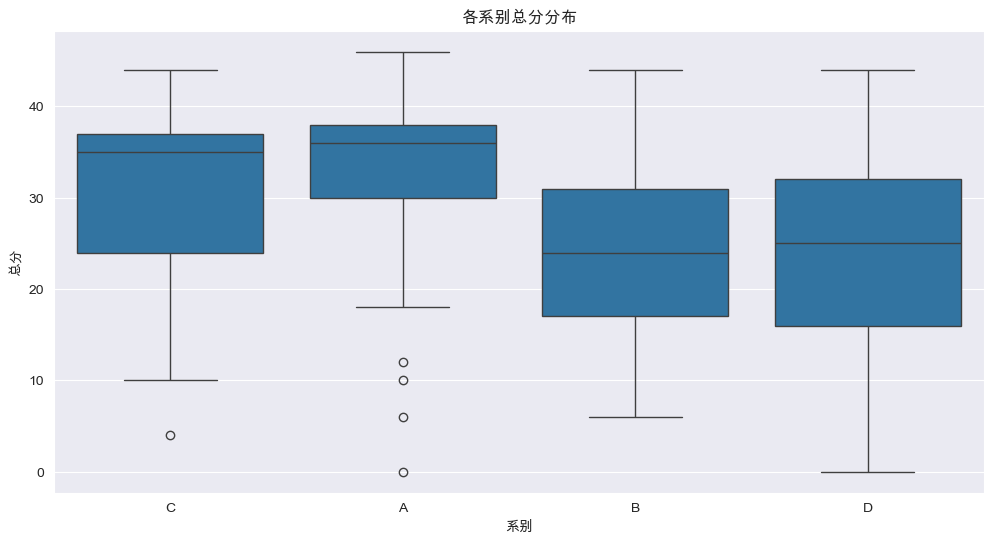

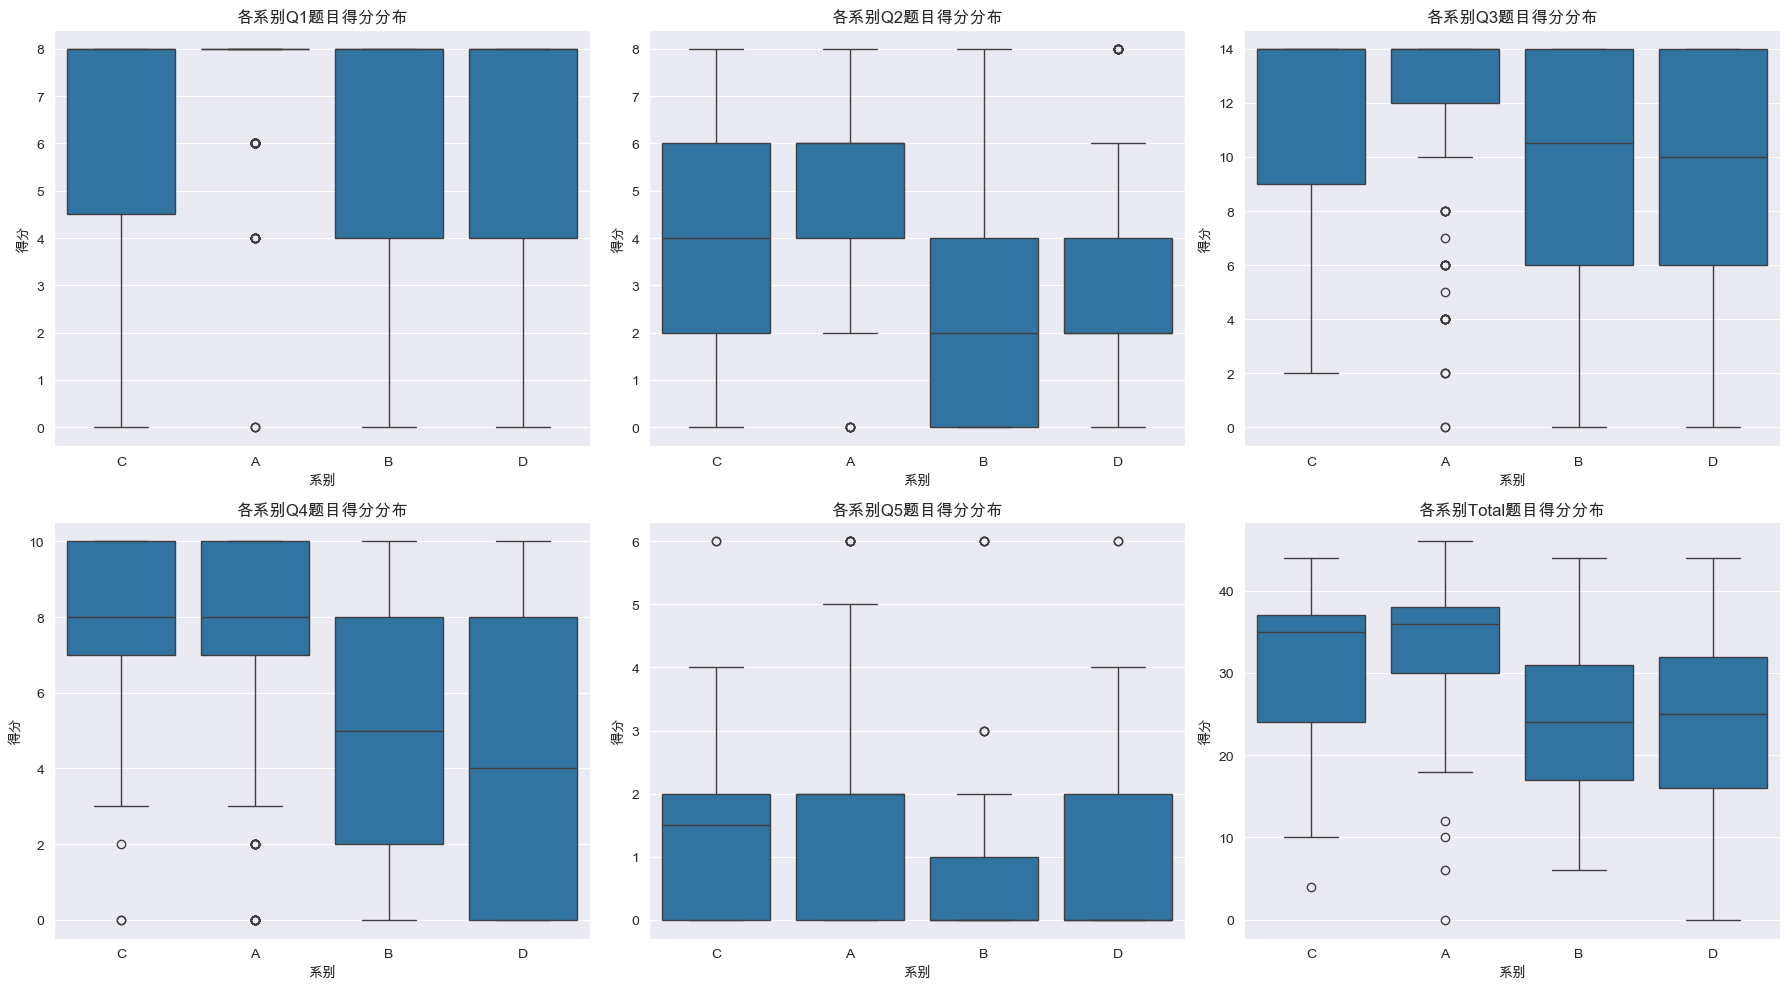

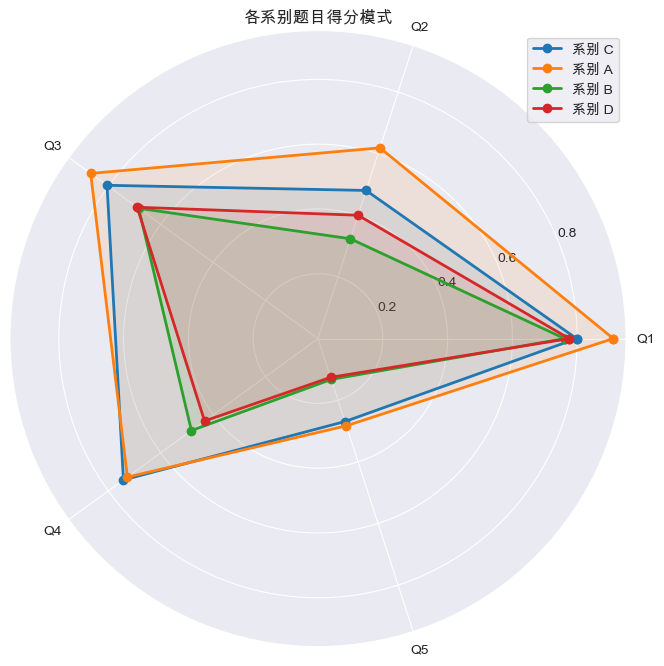

各特征异常值统计:
Q1: 23个 (4.94%)
Q2: 0个 (0.00%)
Q3: 0个 (0.00%)
Q4: 0个 (0.00%)
Q5: 15个 (3.22%)
Total: 0个 (0.00%)

总计: 37个样本存在异常值 (7.94%)

按系别统计异常值比例:
系别 C: 4/26 (15.38%)
系别 A: 10/189 (5.29%)
系别 B: 12/88 (13.64%)
系别 D: 11/163 (6.75%)

按年级统计异常值比例:
年级 2: 32/437 (7.32%)
年级 3: 5/29 (17.24%)


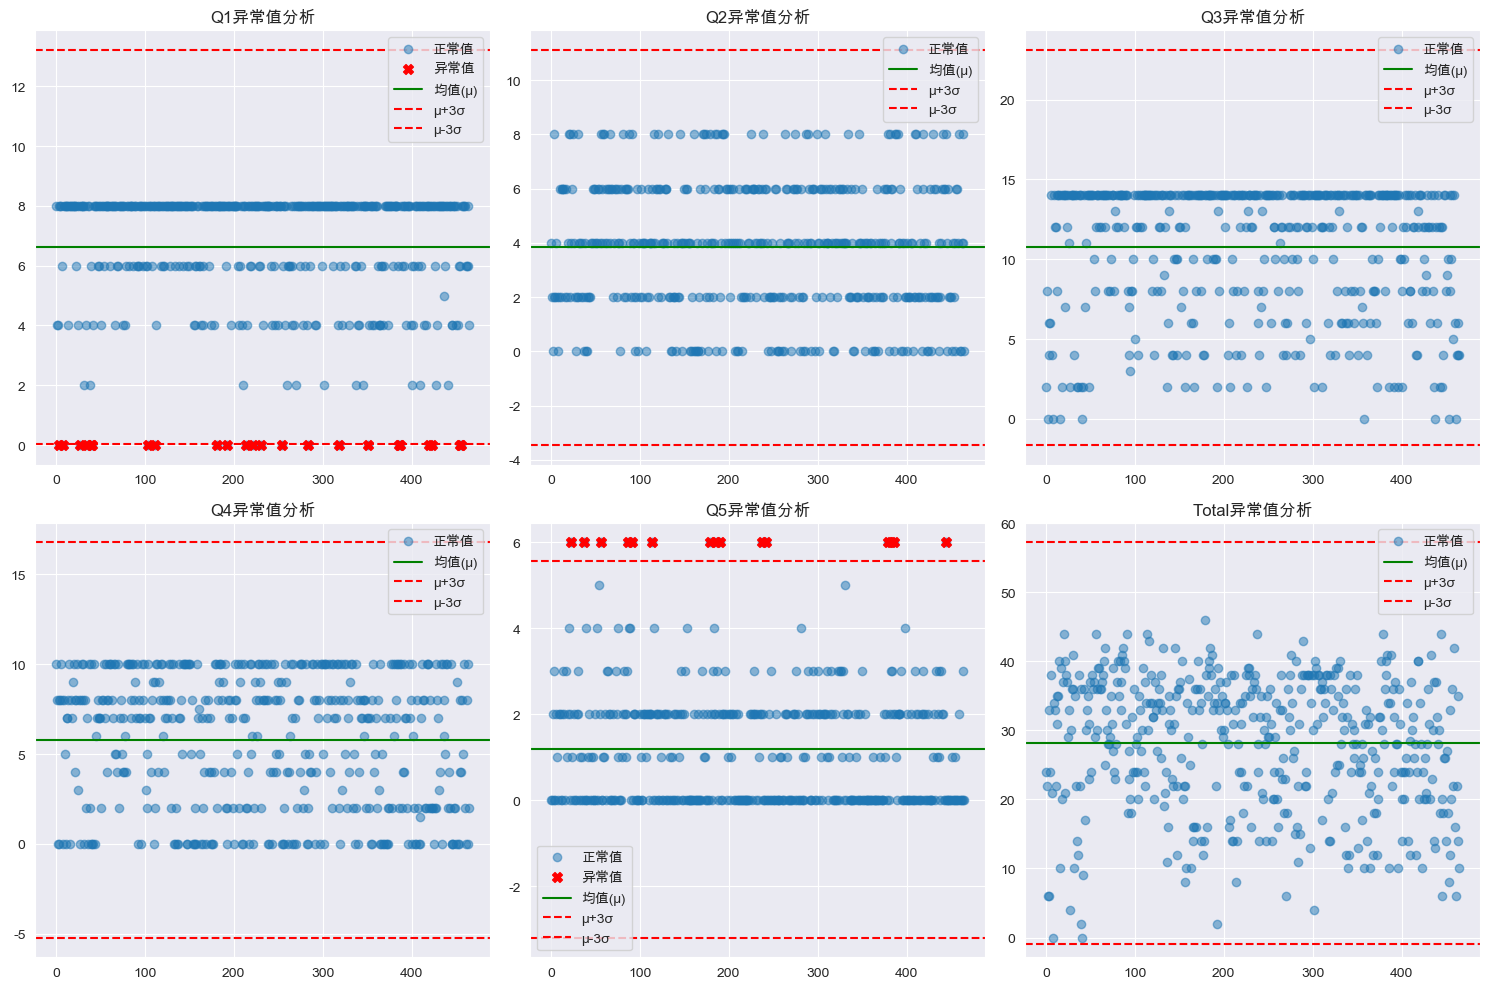


异常值样本详情:


KeyError: 'z_score_total'

In [12]:

# 数据可视化：各系别总分分布
plt.figure(figsize=(12, 6))
sns.boxplot(x='Programme', y='Total', data=df)
plt.title('各系别总分分布')
plt.xlabel('系别')
plt.ylabel('总分')
plt.show()

# 各系别各题目得分分布
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Total']):
    sns.boxplot(x='Programme', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'各系别{col}题目得分分布')
    axes[i].set_xlabel('系别')
    axes[i].set_ylabel('得分')

plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt
import numpy as np

# 准备雷达图数据
categories = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
programmes = df['Programme'].unique()

# 创建雷达图
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# 设置角度
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

for p in programmes:
    # 计算该系的平均分
    stats = df[df['Programme'] == p][categories].mean() / np.array([8, 8, 14, 10, 6])  # 归一化
    stats = np.concatenate((stats, [stats[0]]))

    # 绘制该系的雷达线
    ax.plot(angles, stats, 'o-', linewidth=2, label=f'系别 {p}')
    ax.fill(angles, stats, alpha=0.1)

# 设置雷达图属性
ax.set_thetagrids(angles[:-1] * 180 / np.pi, categories)
ax.set_title('各系别题目得分模式')
ax.legend(loc='upper right')
plt.show()
# 使用Z分数识别异常值
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 定义要分析的数值特征列
score_cols = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Total']

# 计算Z分数并标记异常值
z_scores = pd.DataFrame()
outliers_df = pd.DataFrame(index=df.index)

for col in score_cols:
    # 计算Z分数 Z = (X - μ) / σ
    z_scores[col] = (df[col] - df[col].mean()) / df[col].std()

    # 标记异常值 (|Z| > 3)
    outliers_df[f'{col}_outlier'] = np.abs(z_scores[col]) > 3

# 添加任意列有异常值的标记
outliers_df['any_outlier'] = outliers_df.any(axis=1)

# 统计每个特征的异常值数量
print("各特征异常值统计:")
for col in score_cols:
    outlier_count = outliers_df[f'{col}_outlier'].sum()
    percentage = outlier_count / len(df) * 100
    print(f"{col}: {outlier_count}个 ({percentage:.2f}%)")

# 统计总体异常样本数量
total_outliers = outliers_df['any_outlier'].sum()
print(f"\n总计: {total_outliers}个样本存在异常值 ({total_outliers/len(df)*100:.2f}%)")

# 按系别和年级分析异常值分布
print("\n按系别统计异常值比例:")
for prog in df['Programme'].unique():
    prog_total = (df['Programme'] == prog).sum()
    prog_outliers = ((df['Programme'] == prog) & outliers_df['any_outlier']).sum()
    print(f"系别 {prog}: {prog_outliers}/{prog_total} ({prog_outliers/prog_total*100:.2f}%)")

print("\n按年级统计异常值比例:")
for grade in sorted(df['Grade'].unique()):
    grade_total = (df['Grade'] == grade).sum()
    grade_outliers = ((df['Grade'] == grade) & outliers_df['any_outlier']).sum()
    print(f"年级 {grade}: {grade_outliers}/{grade_total} ({grade_outliers/grade_total*100:.2f}%)")

# 可视化异常值
plt.figure(figsize=(15, 10))
for i, col in enumerate(score_cols):
    plt.subplot(2, 3, i+1)

    # 绘制散点图
    plt.scatter(range(len(df)), df[col], alpha=0.5, label='正常值')

    # 标记异常值
    mask = outliers_df[f'{col}_outlier']
    if mask.sum() > 0:
        plt.scatter(np.where(mask)[0], df.loc[mask, col],
                   color='red', s=50, marker='X', label='异常值')

    # 绘制均值和阈值线
    plt.axhline(df[col].mean(), color='green', linestyle='-', label='均值(μ)')
    plt.axhline(df[col].mean() + 3*df[col].std(), color='red',
               linestyle='--', label='μ+3σ')
    plt.axhline(df[col].mean() - 3*df[col].std(), color='red',
               linestyle='--', label='μ-3σ')

    plt.title(f'{col}异常值分析')
    plt.legend()

plt.tight_layout()
plt.show()

# 输出异常值样本详情
print("\n异常值样本详情:")
outlier_samples = df[outliers_df['any_outlier']]

# 计算Z分数总和并命名
z_score_sum = z_scores.abs().sum(axis=1)
z_score_sum.name = 'z_score_total'

outlier_info = pd.concat([
    outlier_samples[['Programme', 'Grade', 'Gender'] + score_cols],
    z_scores.loc[outlier_samples.index]
], axis=1)

# 按Z分数绝对值总和排序
print(outlier_info.sort_values(by=z_score_sum.name, ascending=False).head(10))

# 保存带异常值标记的数据
df_with_outliers = pd.concat([df, outliers_df], axis=1)
df_with_outliers.to_csv('student_data_with_outliers.csv', index=False)

## 2. 特征差异性分析

在学生成绩的预测过程中，各系别的特征差异性是一个重要的考虑因素。由于不同的学科和考试卷子具有不同的难度分布，不同系别的学生在面对这些考试时，其得分的概率分布（PDF）也可能存在显著差异。这些差异可能源于以下几个因素：
	1.	课程难度：不同系别的课程内容和考试难度不同。例如，理工科类的学生可能面临更为复杂的数学题目，而文科类的学生则更多地涉及写作和理解类的题目。这些差异会导致各系别学生在考试中的得分分布呈现不同的特征。
	2.	学生能力差异：不同系别的学生可能具有不同的学习背景和能力分布。例如，某些系别的学生可能在基础知识掌握上更为扎实，而其他系别的学生则可能在某些领域表现得更为突出。这些能力差异会影响每个系别学生的得分分布。
	3.	考试题目类型：不同学科的考试题目类型有所差异，如选择题、填空题、简答题等，这也会影响不同系别学生的答题表现，从而导致得分分布的不同。

为了更好地预测学生的成绩，我们将首先分析各系别的得分分布。通过为每个系别拟合一个特定的概率密度函数（PDF），我们能够更准确地描述各系别学生成绩的分布特性。我们将采用以下步骤：
	•	拟合各系别的PDF：通过数据分析和分布拟合，我们为每个系别的学生成绩构建一个概率分布模型。这些PDF将反映各系别学生在考试中的得分模式。
	•	贝叶斯预测模型：基于这些系别的PDF分布，我们将利用贝叶斯定理构建一个概率模型，预测一个学生所属的系别。该模型可以根据学生的成绩信息和其他特征，推断其最有可能属于哪个系别。
同时，使用 AIC（Akaike Information Criterion） 作为评价标准的原因，主要是因为它可以帮助你在模型的拟合度与复杂度之间找到一个平衡点。具体来说，AIC 是一个用于模型选择的标准，它考虑了模型的拟合度和自由参数的数量，从而帮助选择在解释数据的同时不过度复杂化的模型。

AIC 的计算公式为：

$AIC = 2k - 2 \ln(L)$

其中：
	•	k 是模型的自由参数数量（即模型的复杂度）。
	•	L 是模型的似然函数值（即模型对数据的拟合度）。


跳过样本量不足的组合: 年级 3, 系别 A, 样本数 1
跳过样本量不足的组合: 年级 3, 系别 B, 样本数 1
跳过样本量不足的组合: 年级 3, 系别 D, 样本数 1

有效的年级-系别组合数: 4
年级 3, 系别 C, Q1: 最佳拟合分布 双峰高斯混合, AIC: -119.1130
年级 3, 系别 C, Q2: 最佳拟合分布 双峰高斯混合, AIC: 125.5378
年级 3, 系别 C, Q3: 最佳拟合分布 右偏双峰对数正态, AIC: -138.8585
年级 3, 系别 C, Q4: 最佳拟合分布 双峰高斯混合, AIC: 125.6125
年级 3, 系别 C, Q5: 最佳拟合分布 双峰高斯混合, AIC: 107.2183
年级 3, 系别 C, Total: 最佳拟合分布 右偏双峰对数正态, AIC: 28.3493
年级 2, 系别 A, Q1: 最佳拟合分布 双峰高斯混合, AIC: -1306.2929
年级 2, 系别 A, Q2: 最佳拟合分布 双峰高斯混合, AIC: 804.6132
年级 2, 系别 A, Q3: 最佳拟合分布 双峰高斯混合, AIC: 715.5967
年级 2, 系别 A, Q4: 最佳拟合分布 双峰高斯混合, AIC: 850.3390
年级 2, 系别 A, Q5: 最佳拟合分布 双峰高斯混合, AIC: -0.4688
年级 2, 系别 A, Total: 最佳拟合分布 双峰高斯混合, AIC: 1226.3733
年级 2, 系别 D, Q1: 最佳拟合分布 双峰高斯混合, AIC: -540.3015
年级 2, 系别 D, Q2: 最佳拟合分布 双峰高斯混合, AIC: 738.5044
年级 2, 系别 D, Q3: 最佳拟合分布 双峰高斯混合, AIC: 68.4180
年级 2, 系别 D, Q4: 最佳拟合分布 双峰高斯混合, AIC: 827.5861
年级 2, 系别 D, Q5: 最佳拟合分布 双峰高斯混合, AIC: -871.9161
年级 2, 系别 D, Total: 最佳拟合分布 双峰高斯混合, AIC: 1187.0817
年级 2, 系别 B, Q1: 最佳拟合分布 双峰高斯混合, AIC: 381.0069
年级 2, 系别 B, Q2: 最佳拟合分

<Figure size 1400x800 with 0 Axes>

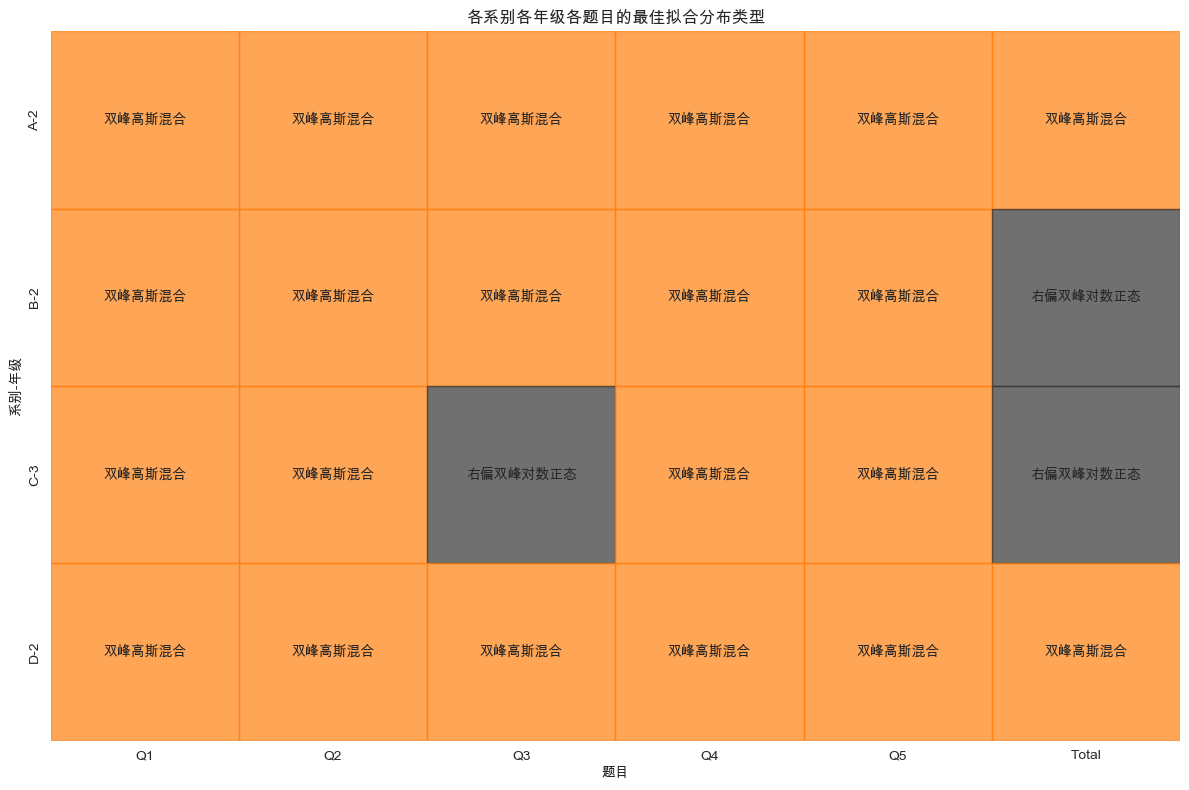


双峰高斯混合的典型案例:
年级: 3, 系别: C, 题目: Q1


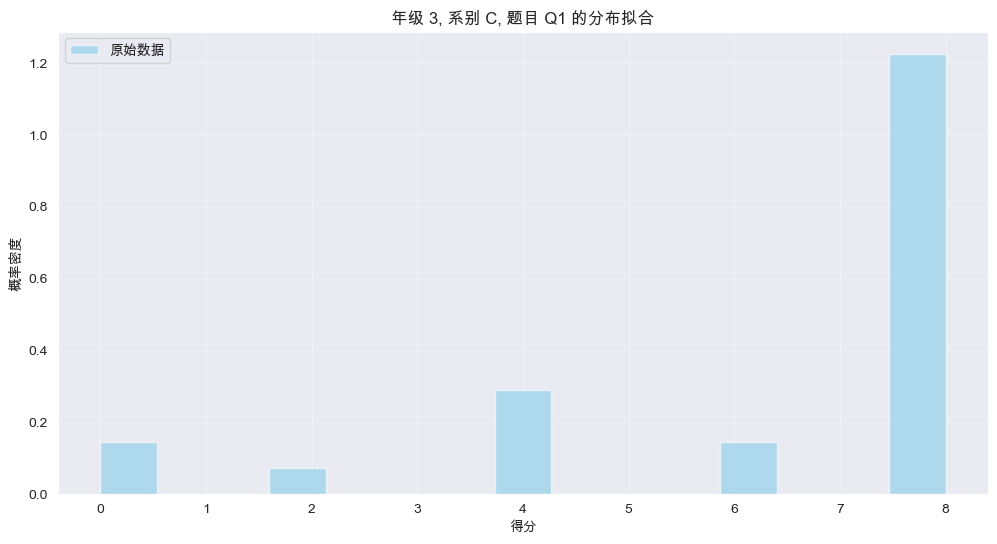

未找到对数正态的典型案例
未找到Gamma的典型案例
未找到双峰对数正态的典型案例


In [3]:
# 扩展分布拟合分析（添加更多分布类型）
results_extended = []
valid_combinations = []
min_sample_size = 10  # 设置一个更高的最小样本量阈值

for grade in df['Grade'].unique():
    grade_data = df[df['Grade'] == grade]

    for programme in grade_data['Programme'].unique():
        prog_data = grade_data[grade_data['Programme'] == programme]
        sample_count = len(prog_data)

        if sample_count >= min_sample_size:
            valid_combinations.append((grade, programme))
        else:
            print(f"跳过样本量不足的组合: 年级 {grade}, 系别 {programme}, 样本数 {sample_count}")

print(f"\n有效的年级-系别组合数: {len(valid_combinations)}")

for grade, programme in valid_combinations:
    prog_data = df[(df['Grade'] == grade) & (df['Programme'] == programme)]
    for col in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Total']:
        data = prog_data[col].dropna().values

        if len(data) <= 5:  # 样本太少，跳过
            continue

        # Beta分布需要归一化的数据 (0-1范围)
        if col == 'Q1' or col == 'Q2':
            data_normalized = data / 8.0  # Q1, Q2满分8分
        elif col == 'Q3':
            data_normalized = data / 14.0  # Q3满分14分
        elif col == 'Q4':
            data_normalized = data / 10.0  # Q4满分10分
        elif col == 'Q5':
            data_normalized = data / 6.0  # Q5满分6分
        elif col == 'Total':
            data_normalized = data / 46.0  # Total满分46分

        data_reshp = data.reshape(-1, 1)
        models = {}
        aic_scores = {}

        # 1. 拟合单峰正态分布
        try:
            params_norm = stats.norm.fit(data)
            aic_norm = 2 * 2 + 2 * (-np.sum(stats.norm.logpdf(data, *params_norm)))
            models['单峰正态'] = params_norm
            aic_scores['单峰正态'] = aic_norm
        except:
            pass

        # 2. 拟合双峰高斯混合模型
        try:
            gmm = GaussianMixture(n_components=2, random_state=42)
            gmm.fit(data_reshp)
            aic_gmm = 2 * 6 + 2 * (-gmm.score(data_reshp) * len(data))  # 6个参数：2均值+2方差+2权重
            models['双峰高斯混合'] = gmm
            aic_scores['双峰高斯混合'] = aic_gmm
        except:
            pass

        # 3. 拟合对数正态分布 (双向)
        if np.all(data > 0):
            try:
                # 3.1 标准对数正态分布（右偏）
                params_lognorm = stats.lognorm.fit(data)
                aic_lognorm = 2 * 3 + 2 * (-np.sum(stats.lognorm.logpdf(data, *params_lognorm)))
                models['右偏对数正态'] = params_lognorm
                aic_scores['右偏对数正态'] = aic_lognorm
            except:
                pass

        # 3.2 反向对数正态分布（左偏）
        max_val = np.max(data)
        if np.all(max_val - data > 0):
            try:
                reversed_data = max_val - data + 1  # 将数据反转并确保全为正值
                params_rev_lognorm = stats.lognorm.fit(reversed_data)
                aic_rev_lognorm = 2 * 3 + 2 * (-np.sum(stats.lognorm.logpdf(reversed_data, *params_rev_lognorm)))
                models['左偏对数正态'] = params_rev_lognorm
                aic_scores['左偏对数正态'] = aic_rev_lognorm
            except:
                pass

        # 4. 拟合Gamma分布 (仅对正值有效)
        if np.all(data > 0):
            try:
                params_gamma = stats.gamma.fit(data)
                aic_gamma = 2 * 3 + 2 * (-np.sum(stats.gamma.logpdf(data, *params_gamma)))
                models['Gamma'] = params_gamma
                aic_scores['Gamma'] = aic_gamma
            except:
                pass

        # 5. 拟合Beta分布 (仅对[0,1]区间的值有效)
        if np.all(data_normalized >= 0) and np.all(data_normalized <= 1):
            try:
                # 确保数据在(0,1)之间，避免极端值
                beta_data = np.clip(data_normalized, 0.001, 0.999)
                params_beta = stats.beta.fit(beta_data)
                aic_beta = 2 * 4 + 2 * (-np.sum(stats.beta.logpdf(beta_data, *params_beta)))
                models['Beta'] = params_beta
                aic_scores['Beta'] = aic_beta
            except:
                pass

                # 6.1 拟合右偏双峰对数正态��合模型

        # 6.1 拟合右偏双峰对数正态混合模型
        if np.all(data > 0):
            try:
                # 先将数据取对数，然后拟合高斯混合模型
                log_data = np.log(data).reshape(-1, 1)
                gmm_log = GaussianMixture(n_components=2, random_state=42)
                gmm_log.fit(log_data)
                aic_gmm_log = 2 * 6 + 2 * (-gmm_log.score(log_data) * len(data))
                models['右偏双峰对数正态'] = gmm_log
                aic_scores['右偏双峰对数正态'] = aic_gmm_log
            except:
                pass

        # 6.2 拟合左偏双峰对数正态混合模型
        max_val = np.max(data)
        if np.all(max_val - data > 0):
            try:
                # 将数据反转并确保全为正值，再取对数
                reversed_data = max_val - data + 1
                log_reversed_data = np.log(reversed_data).reshape(-1, 1)

                # 拟合高斯混合模型
                gmm_log_rev = GaussianMixture(n_components=2, random_state=42)
                gmm_log_rev.fit(log_reversed_data)
                aic_gmm_log_rev = 2 * 6 + 2 * (-gmm_log_rev.score(log_reversed_data) * len(data))
                models['左偏双峰对数正态'] = gmm_log_rev
                aic_scores['左偏双峰对数正态'] = aic_gmm_log_rev
            except:
                pass

        # 找出AIC最低的模型
        if aic_scores:
            best_model_name = min(aic_scores, key=aic_scores.get)
            best_aic = aic_scores[best_model_name]

            results_extended.append([grade, programme, col, best_model_name, best_aic])
            print(f"年级 {grade}, 系别 {programme}, {col}: 最佳拟合分布 {best_model_name}, AIC: {best_aic:.4f}")

# 将扩展的拟合结果转换为DataFrame
results_extended_df = pd.DataFrame(results_extended, columns=['Grade', 'Programme', 'Question', 'Best_Model', 'AIC'])

# 可视化扩展后的拟合结果
plt.figure(figsize=(14, 8))
best_extended_models = results_extended_df.pivot_table(index=['Programme', 'Grade'], columns='Question',
                                                       values='Best_Model',
                                                       aggfunc=lambda x: x.iloc[0] if len(x) > 0 else None)

# 创建颜色映射
model_palette = {
    '单峰正态': '#1f77b4',
    '双峰高斯混合': '#ff7f0e',
    '对数正态': '#2ca02c',
    'Gamma': '#d62728',
    'Beta': '#9467bd',
    '双峰对数正态': '#8c564b'
}

# 创建颜色编码矩阵
color_matrix = best_extended_models.applymap(lambda x: model_palette.get(x, '#333333') if x else '#eeeeee')

plt.figure(figsize=(12, 8))
ax = sns.heatmap(pd.notna(best_extended_models), cmap='binary',
                 cbar=False, annot=best_extended_models, fmt='')

# 设置热图单元格颜色
for i in range(len(color_matrix.index)):
    for j in range(len(color_matrix.columns)):
        if pd.notna(best_extended_models.iloc[i, j]):
            ax.add_patch(plt.Rectangle((j, i), 1, 1,
                                       color=color_matrix.iloc[i, j],
                                       fill=True, alpha=0.7))

plt.title('各系别各年级各题目的最佳拟合分布类型')
plt.xlabel('题目')
plt.ylabel('系别-年级')
plt.tight_layout()
plt.show()


# 可视化比较函数
def visualize_distribution_fits(grade, programme, question):
    from scipy import stats
    data = df[(df['Grade'] == grade) & (df['Programme'] == programme)][question].dropna().values

    if len(data) < 5:
        print(f"数据太少，无法可视化")
        return

    x = np.linspace(min(data) * 0.8, max(data) * 1.2, 1000)

    plt.figure(figsize=(12, 6))
    plt.hist(data, bins=15, density=True, alpha=0.6, color='skyblue', label='原始数据')

    # 拟合并绘制各种分布
    if np.all(data > 0):
        # 正态分布
        try:
            params_norm = stats.norm.fit(data)
            plt.plot(x, stats.norm.pdf(x, *params_norm), 'r-', label='正态分布')
        except Exception as e:
            print(f"正态分布拟合失败: {e}")

        # 右偏对数正态分布
        try:
            params_lognorm = stats.lognorm.fit(data)
            plt.plot(x, stats.lognorm.pdf(x, *params_lognorm), 'g--', label='右偏对数正态')
        except Exception as e:
            print(f"右偏对数正态拟合失败: {e}")

        # 左偏对数正态分布
        try:
            max_val = np.max(data)
            if np.all(max_val - data > 0):
                reversed_data = max_val - data + 1
                params_rev_lognorm = stats.lognorm.fit(reversed_data)
                rev_x = max_val - x + 1
                rev_pdf = stats.lognorm.pdf(rev_x, *params_rev_lognorm)
                pdf = rev_pdf[::-1]
                plt.plot(x, pdf, 'c:', label='左偏对数正态')
        except Exception as e:
            print(f"左偏对数正态拟合失败: {e}")

        # Gamma分布
        try:
            params_gamma = stats.gamma.fit(data)
            plt.plot(x, stats.gamma.pdf(x, *params_gamma), 'm-.', label='Gamma分布')
        except Exception as e:
            print(f"Gamma分布拟合失败: {e}")

        # 双峰高斯混合
        try:
            gmm = GaussianMixture(n_components=2, random_state=42)
            gmm.fit(data.reshape(-1, 1))
            gmm_x = np.linspace(min(data), max(data), 1000).reshape(-1, 1)
            gmm_y = np.exp(gmm.score_samples(gmm_x))
            plt.plot(gmm_x, gmm_y, 'b-', label='双峰高斯混合')
        except Exception as e:
            print(f"双峰高斯混合拟合失败: {e}")

        # 右偏双峰对数正态混合
        try:
            if np.all(data > 0):
                log_data = np.log(data).reshape(-1, 1)
                gmm_log = GaussianMixture(n_components=2, random_state=42)
                gmm_log.fit(log_data)
                x_vals = np.linspace(min(data), max(data), 1000)
                log_x = np.log(x_vals).reshape(-1, 1)
                log_pdf = np.exp(gmm_log.score_samples(log_x))
                pdf = log_pdf / x_vals
                plt.plot(x_vals, pdf, 'y-', label='右偏双峰对数正态')
        except Exception as e:
            print(f"右偏双峰对数正态拟合失败: {e}")

        # 左偏双峰对数正态混合
        try:
            max_val = np.max(data)
            if np.all(max_val - data > 0):
                reversed_data = max_val - data + 1
                log_reversed_data = np.log(reversed_data).reshape(-1, 1)
                gmm_log_rev = GaussianMixture(n_components=2, random_state=42)
                gmm_log_rev.fit(log_reversed_data)
                x_vals = np.linspace(min(data), max(data), 1000)
                reversed_x = max_val - x_vals + 1
                log_reversed_x = np.log(reversed_x).reshape(-1, 1)
                log_pdf = np.exp(gmm_log_rev.score_samples(log_reversed_x))
                pdf = log_pdf / reversed_x
                pdf = pdf[::-1]
                plt.plot(x_vals, pdf, 'm--', label='左偏双峰对数正态')
        except Exception as e:
            print(f"左偏双峰对数正态拟合失败: {e}")

    plt.title(f'年级 {grade}, 系别 {programme}, 题目 {question} 的分布拟合')
    plt.xlabel('得分')
    plt.ylabel('概率密度')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


# 找出每种分布类型的典型案例进行可视化展示
for model_type in ['双峰高斯混合', '对数正态', 'Gamma', '双峰对数正态']:
    try:
        sample = results_extended_df[results_extended_df['Best_Model'] == model_type].iloc[0]
        print(f"\n{model_type}的典型案例:")
        print(f"年级: {sample['Grade']}, 系别: {sample['Programme']}, 题目: {sample['Question']}")
        visualize_distribution_fits(sample['Grade'], sample['Programme'], sample['Question'])
    except IndexError:
        print(f"未找到{model_type}的典型案例")

### 3. 题目得分模式分析
事实上，对于完全自然的得分来说，正态分布最符合各个分段的人数分布。但是由于考试的难度和学生的能力差异（比如各地生源导致学生能力分布不均），可能会导致得分分布偏离正态分布而形成双峰分布。同时，某些专业同学压力较大，学习欲望强烈，甚至可以使得概率密度函数转为“马太分布”。因此，我们需要考虑其他分布模型来更好地拟合数据。
基于贝叶斯构建不同年级的预测模型，同时进行交叉验证

In [4]:
# 基于贝叶斯构建不同年级的预测模型
# 创建特征工程函数
def create_features(df_input, with_interactions=True):
    X = df_input[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Gender']]

    # 添加交互特征
    if with_interactions:
        # 添加比例特征
        esp = 0.0000001
        for i, j in itertools.combinations(range(1, 6), 2):
            X[f'Q{i}_to_Q{j}'] = df_input[f'Q{i}'] / (df_input[f'Q{j}'] + esp)

        # 添加统计特征
        X['mean'] = df_input[['Q1', 'Q2', 'Q3', 'Q4', 'Q5']].mean(axis=1)
        X['std'] = df_input[['Q1', 'Q2', 'Q3', 'Q4', 'Q5']].std(axis=1)
        X['max_min_diff'] = df_input[['Q1', 'Q2', 'Q3', 'Q4', 'Q5']].max(axis=1) - df_input[
            ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']].min(axis=1)

    # 将Gender转为数值型
    X['Gender'] = X['Gender'].astype(int)

    return X


# 按年级分别建模
results_by_grade = {}
feature_importances = {}
confusion_matrices = {}

for grade in df['Grade'].unique():
    grade_df = df[df['Grade'] == grade]
    if grade_df.size < 30:  # 数据不足，跳过
        continue

    # 特征工程
    X = create_features(grade_df)
    y = grade_df['Programme']

    # 过滤掉样本数量太少的类别
    programme_counts = y.value_counts()
    valid_programmes = programme_counts[programme_counts >= 3].index  # 至少需要3个样本
    if len(valid_programmes) < 2:  # 需要至少2个有效类别
        print(f"年级 {grade} 没有足够的样本数量，跳过")
        continue

    mask = y.isin(valid_programmes)
    X = X[mask]
    y = y[mask]

    # 使用交叉验证代替简单的训练测试集分割
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(f_classif, k=min(10, X.shape[1]))),
        ('classifier', GaussianNB())
    ])

    # 训练与评估
    cv_scores = []
    all_y_pred = []
    all_y_true = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        cv_scores.append((y_pred == y_test).mean())

        all_y_pred.extend(y_pred)
        all_y_true.extend(y_test)

    # 计算平均准确率
    accuracy = np.mean(cv_scores)
    results_by_grade[grade] = accuracy

    # 保存混淆矩阵
    confusion_matrices[grade] = confusion_matrix(all_y_true, all_y_pred)

    # 训练完整模型获取特征重要性
    pipeline.fit(X, y)
    selected_indices = pipeline.named_steps['feature_selection'].get_support(indices=True)
    selected_features = X.columns[selected_indices]
    feature_scores = pipeline.named_steps['feature_selection'].scores_[selected_indices]
    feature_importances[grade] = dict(zip(selected_features, feature_scores))

    print(f"\n年级 {grade} 的系别预测准确率: {accuracy:.4f}")
    print(f"年级 {grade} 的分类报告:")
    print(classification_report(all_y_true, all_y_pred))
    print(f"最重要的特征: {selected_features.tolist()}")

年级 3 没有足够的样本数量，跳过

年级 2 的系别预测准确率: 0.5356
年级 2 的分类报告:
              precision    recall  f1-score   support

           A       0.60      0.82      0.69       188
           B       0.30      0.15      0.20        87
           D       0.49      0.41      0.45       162

    accuracy                           0.54       437
   macro avg       0.46      0.46      0.45       437
weighted avg       0.50      0.54      0.50       437

最重要的特征: ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q1_to_Q2', 'Q1_to_Q4', 'Q1_to_Q5', 'Q3_to_Q5', 'mean']


### 4. 构建预测模型
基于学生得分模式预测所属系别：

In [5]:
# 导入必要的库
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 设置随机种子确保结果可复现
np.random.seed(42)


# 定义特征工程函数
def create_advanced_features(df_input):
    eps = 0.0000001
    # 基础特征
    X = df_input[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Gender']]

    # 题目得分比例特征
    for i in range(1, 6):
        for j in range(i + 1, 6):
            X[f'Q{i}_to_Q{j}'] = df_input[f'Q{i}'] / (df_input[f'Q{j}'] + eps)

    # 统计特征
    X['mean_score'] = df_input[['Q1', 'Q2', 'Q3', 'Q4', 'Q5']].mean(axis=1)
    X['std_score'] = df_input[['Q1', 'Q2', 'Q3', 'Q4', 'Q5']].std(axis=1)
    X['range_score'] = df_input[['Q1', 'Q2', 'Q3', 'Q4', 'Q5']].max(axis=1) - df_input[
        ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']].min(axis=1)
    X['cv_score'] = X['std_score'] / (X['mean_score'] + eps)  # 变异系数

    # 归一化题目分数（考虑题目满分不同）
    max_scores = [8, 8, 14, 10, 6]  # 每题满分
    for i in range(1, 6):
        X[f'Q{i}_norm'] = df_input[f'Q{i}'] / max_scores[i - 1]

    return X


# 准备数据
X = create_advanced_features(df)
y = df['Programme']

### 模型选择和训练


In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy import stats

class FlexibleBayesClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, feature_distribution_map=None, random_state=42):
        """
        初始化灵活贝叶斯分类器

        参数:
            feature_distribution_map: 字典，指定每个(类别,特征)对应的分布类型
                例如 {('A', 'Q1'): 'bimodal_gaussian', ('A', 'Q2'): 'log_normal'}
            random_state: 随机种子
        """
        self.feature_distribution_map = feature_distribution_map or {}
        self.random_state = random_state
        self.models = {}  # 存储每个类别每个特征的分布模型
        self.priors = {}  # 存储每个类别的先验概率
        self.classes_ = None
        self.features_ = None

    def _fit_distribution(self, X, feature_idx, feature_name, distribution_type):
        """为特定特征拟合指定的分布类型"""
        data = X[:, feature_idx]

        if distribution_type == 'bimodal_gaussian':
            model = GaussianMixture(
                n_components=2,
                covariance_type='full',
                random_state=self.random_state
            )
            # 重塑数据为[-1,1]数组(GMM需要)
            model.fit(data.reshape(-1, 1))
            return model

        elif distribution_type == 'log_normal':
            # 对于对数正态分布，我们需要确保数据为正
            pos_data = np.maximum(data, 1e-10)
            params = stats.lognorm.fit(pos_data)
            return {'distribution': 'log_normal', 'params': params}

        elif distribution_type == 'bimodal_log_normal':
            # 双峰右偏对数正态分布
            # 先确保数据为正值
            pos_data = np.maximum(data, 1e-10)
            # 取对数转换
            log_data = np.log(pos_data).reshape(-1, 1)
            # 在对数空间拟合双峰高斯混合模型
            log_model = GaussianMixture(
                n_components=2,
                covariance_type='full',
                random_state=self.random_state
            )
            log_model.fit(log_data)
            return {'distribution': 'bimodal_log_normal', 'model': log_model}

        else:
            # 默认使用双峰高斯
            model = GaussianMixture(
                n_components=2,
                covariance_type='full',
                random_state=self.random_state
            )
            model.fit(data.reshape(-1, 1))
            return model

    def fit(self, X, y):
        """
        训练贝叶斯分类器

        参数:
            X: 特征矩阵
            y: 目标类别
        """
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape
        self.features_ = np.arange(n_features)

        # 计算先验概率
        for cls in self.classes_:
            self.priors[cls] = np.mean(y == cls)

        # 为每个类别的每个特征拟合分布
        for cls in self.classes_:
            cls_samples = X[y == cls]
            if len(cls_samples) < 5:  # 样本太少，跳过
                continue

            self.models[cls] = {}

            for i, feature_idx in enumerate(self.features_):
                feature_name = f"feature_{i}"  # 默认特征名

                # 确定该(类别,特征)对应的分布类型
                dist_type = self.feature_distribution_map.get((cls, feature_name), 'bimodal_gaussian')

                # 拟合分布
                self.models[cls][feature_idx] = self._fit_distribution(
                    cls_samples, feature_idx, feature_name, dist_type
                )

        return self

    def _score_sample(self, x, cls):
        """计算样本在给定类别下的对数似然"""
        log_likelihood = 0.0

        for feature_idx in self.features_:
            if cls not in self.models or feature_idx not in self.models[cls]:
                continue

            model = self.models[cls][feature_idx]
            value = x[feature_idx]

            # 根据分布类型计算似然
            if isinstance(model, GaussianMixture):  # 双峰高斯
                # GMM需要2D数据
                ll = model.score_samples(np.array([[value]]))
                log_likelihood += ll[0]

            elif isinstance(model, dict) and model['distribution'] == 'log_normal':
                # 对数正态分布
                params = model['params']
                if value <= 0:  # 对数正态要求值为正
                    log_likelihood += np.log(1e-10)  # 极小概率
                else:
                    ll = stats.lognorm.logpdf(value, *params)
                    log_likelihood += ll

            elif isinstance(model, dict) and model['distribution'] == 'bimodal_log_normal':
                # 双峰右偏对数正态分布
                log_model = model['model']
                if value <= 0:  # 对数分布要求值为正
                    log_likelihood += np.log(1e-10)  # 极小概率
                else:
                    log_value = np.log(value)
                    ll = log_model.score_samples(np.array([[log_value]]))
                    log_likelihood += ll[0]

            else:  # 默认双峰高斯
                ll = 0  # 这里应该不会执行到，但为了安全起见
                log_likelihood += ll

        return log_likelihood

    def predict_proba(self, X):
        """
        预测每个样本属于各个类别的概率

        参数:
            X: 特征矩阵

        返回:
            概率矩阵，形状为(n_samples, n_classes)
        """
        if not self.models:
            raise ValueError("模型尚未训练")

        n_samples = X.shape[0]
        n_classes = len(self.classes_)

        # 初始化对数似然矩阵
        log_likelihoods = np.zeros((n_samples, n_classes))

        # 计算每个样本在每个类别下的对数似然
        for i, x in enumerate(X):
            for j, cls in enumerate(self.classes_):
                if cls in self.models:
                    # 计算对数似然
                    log_likelihood = self._score_sample(x, cls)
                    # 贝叶斯公式: P(C|X) ∝ P(X|C) * P(C)
                    log_likelihoods[i, j] = log_likelihood + np.log(self.priors[cls])
                else:
                    log_likelihoods[i, j] = -np.inf

        # 处理数值问题：从每一行减去最大值以防溢出
        max_log_probs = np.max(log_likelihoods, axis=1, keepdims=True)
        log_probs_stable = log_likelihoods - max_log_probs

        # 取指数并归一化
        probs = np.exp(log_probs_stable)
        row_sums = np.sum(probs, axis=1, keepdims=True)

        # 处理零概率行
        zero_rows = (row_sums == 0).ravel()
        if np.any(zero_rows):
            probs[zero_rows, :] = 1.0 / n_classes
            row_sums[zero_rows] = 1.0

        # 归一化概率
        probs = probs / row_sums

        # 检查并处理NaN
        if np.any(np.isnan(probs)):
            nan_rows = np.any(np.isnan(probs), axis=1)
            probs[nan_rows, :] = 1.0 / n_classes

        return probs

    def predict(self, X):
        """预测类别"""
        probs = self.predict_proba(X)
        return self.classes_[np.argmax(probs, axis=1)]

# 按年级分别训练模型
for grade in df['Grade'].unique():
    print(f"\n开始训练年级 {grade} 的模型")
    grade_df = df[df['Grade'] == grade]

    X_grade = create_advanced_features(grade_df)
    y_grade = grade_df['Programme']

    # 检查样本量
    programme_counts = y_grade.value_counts()
    valid_programmes = programme_counts[programme_counts >= 5].index
    if len(valid_programmes) < 2:
        print(f"年级 {grade} 的有效系别数量不足，跳过")
        continue

    # 过滤有效系别
    mask = y_grade.isin(valid_programmes)
    X_grade = X_grade[mask]
    y_grade = y_grade[mask]

    # 为每个(系别,特征)组合确定最佳分布类型
    feature_distribution_map = {}

    # 这里可以根据你之前的分析结果填充feature_distribution_map
    # 例如:
    if grade == 3 and 'C' in valid_programmes:
        feature_distribution_map[('C', 'Q1')] = 'bimodal_gaussian'
        feature_distribution_map[('C', 'Q2')] = 'bimodal_gaussian'
        feature_distribution_map[('C', 'Q3')] = 'log_normal'  # 右偏双峰对数正态
        feature_distribution_map[('C', 'Q4')] = 'bimodal_gaussian'
        feature_distribution_map[('C', 'Q5')] = 'bimodal_gaussian'

    if grade == 2 and 'B' in valid_programmes:
        feature_distribution_map[('B', 'Total')] = 'log_normal'  # 右偏双峰对数正态

    # 交叉验证
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # 创建灵活贝叶斯模型
    bayes_model = FlexibleBayesClassifier(
        feature_distribution_map=feature_distribution_map,
        random_state=42
    )

    # 使用Pipeline进行特征标准化和模型训练
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', bayes_model)
    ])

    # 训练模型
    pipeline.fit(X_grade, y_grade)

    # 进���交叉验证评估
    cv_scores = []

    for train_idx, test_idx in cv.split(X_grade, y_grade):
        X_train, X_test = X_grade.iloc[train_idx], X_grade.iloc[test_idx]
        y_train, y_test = y_grade.iloc[train_idx], y_grade.iloc[test_idx]

        # 训练模型
        pipeline.fit(X_train, y_train)

        # 预测并评估
        y_pred = pipeline.predict(X_test)
        accuracy = np.mean(y_pred == y_test)
        cv_scores.append(accuracy)

    # 保存最佳模型
    grade_models[grade] = {
        'model': pipeline,
        'features': X_grade.columns,
        'accuracy': np.mean(cv_scores),
        'feature_distribution_map': feature_distribution_map
    }

    print(f"年级 {grade} 模型训练完成，交叉验证平均准确率: {np.mean(cv_scores):.4f}")


开始训练年级 3 的模型
年级 3 的有效系别数量不足，跳过

开始训练年级 2 的模型
年级 2 模型训练完成，交叉验证平均准确率: 0.5057


### 3. 模型评估


年级 2 模型评估结果:
              precision    recall  f1-score   support

           A       0.63      0.63      0.63        57
           B       0.33      0.23      0.27        26
           D       0.42      0.49      0.45        49

    accuracy                           0.50       132
   macro avg       0.46      0.45      0.45       132
weighted avg       0.49      0.50      0.49       132



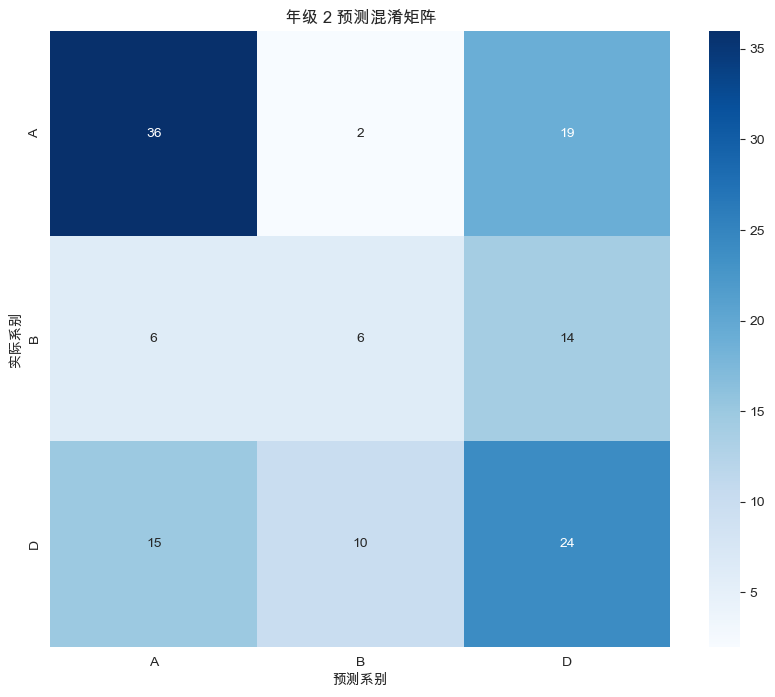

In [7]:
# 评估所有模型
for grade, model_info in grade_models.items():
    model = model_info['model']
    grade_df = df[df['Grade'] == grade]

    # 创建特征
    X_grade = create_advanced_features(grade_df)
    y_grade = grade_df['Programme']

    # 过滤有效系别
    programme_counts = y_grade.value_counts()
    valid_programmes = programme_counts[programme_counts >= 5].index
    mask = y_grade.isin(valid_programmes)
    X_grade = X_grade[mask]
    y_grade = y_grade[mask]

    # 分割测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X_grade, y_grade, test_size=0.3, random_state=42, stratify=y_grade
    )

    # 预测并评估
    y_pred = model.predict(X_test)
    print(f"\n年级 {grade} 模型评估结果:")
    print(classification_report(y_test, y_pred))

    # 混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted(valid_programmes),
                yticklabels=sorted(valid_programmes))
    plt.title(f'年级 {grade} 预测混淆矩阵')
    plt.xlabel('预测系别')
    plt.ylabel('实际系别')
    plt.show()

### 4. 特征重要性和模型解释


年级 2 的模型信息:
模型类型: FlexibleBayesClassifier
���型参数: {'feature_distribution_map': {('B', 'Total'): 'log_normal'}, 'random_state': 42}


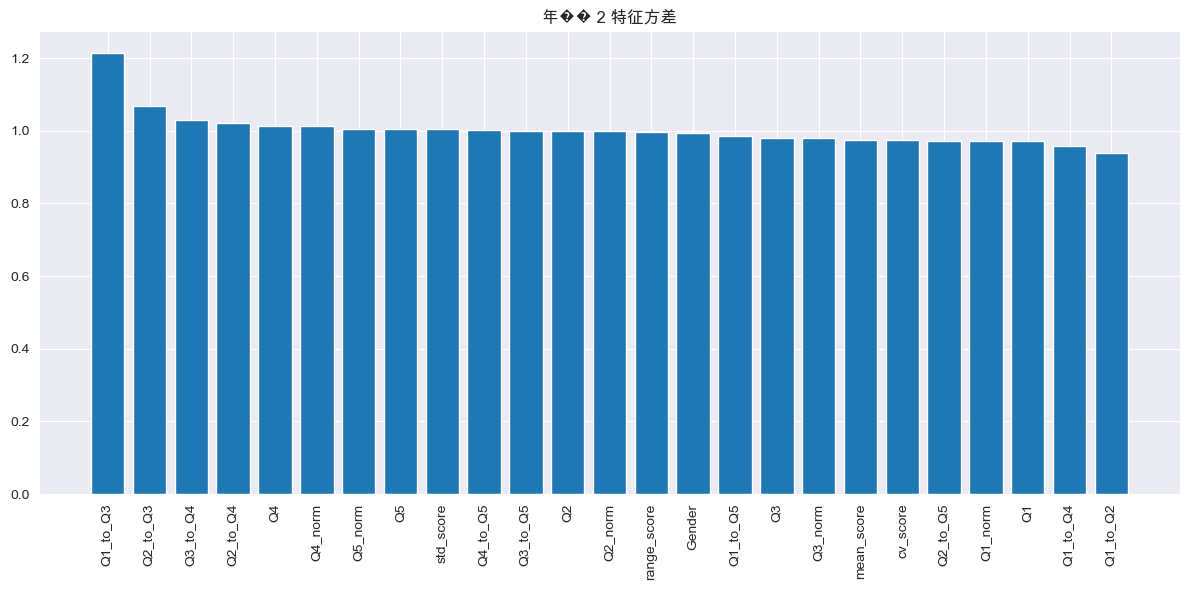

SHAP分析失败: No module named 'shap'


In [8]:
# 分析特征重要性
for grade, model_info in grade_models.items():
    pipeline = model_info['model']
    features = model_info['features']

    try:
        # 尝试获取分类器
        classifier = pipeline.named_steps['classifier']

        # 如果是网格搜索对象，还需要获取其最佳估计器
        if hasattr(classifier, 'best_estimator_'):
            classifier = classifier.best_estimator_

        # 对于贝叶斯模型，我们无���直接获取特征重要性
        # 可以通过各类别的分布差异来估计特征重要性
        print(f"\n年级 {grade} 的模型信息:")
        print(f"模型类型: {type(classifier).__name__}")
        print(f"���型参数: {classifier.get_params()}")

        # 获取测试数据
        grade_df = df[df['Grade'] == grade]
        X_grade = create_advanced_features(grade_df)
        y_grade = grade_df['Programme']

        # 过滤有效系别
        programme_counts = y_grade.value_counts()
        valid_programmes = programme_counts[programme_counts >= 5].index
        mask = y_grade.isin(valid_programmes)
        X_grade = X_grade[mask]
        y_grade = y_grade[mask]

        # 使用标准化数据的方差来近似特征重要性
        X_scaled = pipeline.named_steps['scaler'].transform(X_grade)
        feature_vars = np.var(X_scaled, axis=0)

        # 绘制特征方差图
        plt.figure(figsize=(12, 6))
        plt.title(f'年�� {grade} 特征方差')
        indices = np.argsort(feature_vars)[::-1]
        plt.bar(range(len(feature_vars)), feature_vars[indices], align='center')
        plt.xticks(range(len(feature_vars)), np.array(features)[indices], rotation=90)
        plt.tight_layout()
        plt.show()

        # 使用各类别的SHAP值来分析特征重要性
        # 对于贝叶斯模型，可以使用KernelExplainer
        if len(X_grade) > 100:
            # 如果数据过多，随机选择子集用于SHAP分析以提高效率
            sample_idx = np.random.choice(len(X_grade), min(100, len(X_grade)), replace=False)
            X_sample = X_grade.iloc[sample_idx]
        else:
            X_sample = X_grade

        try:
            import shap
            # 使用KernelExplainer，适用于任何模型
            explainer = shap.KernelExplainer(pipeline.predict_proba, X_sample)
            shap_values = explainer.shap_values(X_sample.iloc[:20])  # 取前20个样本加速计算

            # 绘制SHAP摘要图
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values, X_sample.iloc[:20], feature_names=features)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"SHAP分析失败: {e}")

    except Exception as e:
        print(f"无法分析年级 {grade} 的特征重要性: {e}")

### 5. 贝叶斯预测演示
测试预训练的贝叶斯模型在典型学生案例上的预测效果


贝叶斯预测演示:
{'A': np.float64(0.0), 'B': np.float64(0.0), 'D': np.float64(1.0)}
学生得分: [4, 0, 0, 0, 2], 年级: 2, 性别: 2
预测系别: D (❌ 错误), 预期系别: A
各系别概率: A: 0.0000, B: 0.0000, D: 1.0000

{'A': np.float64(1.0002494945799461e-17), 'B': np.float64(1.7020980249418418e-07), 'D': np.float64(0.9999998297901974)}
学生得分: [8, 2, 2, 0, 0], 年级: 2, 性别: 2
预测系别: D (✅ 正确), 预期系别: D
各系别概率: A: 0.0000, B: 0.0000, D: 1.0000

{'A': np.float64(0.9225683568626271), 'B': np.float64(1.9272150457285313e-10), 'D': np.float64(0.07743164294465152)}
学生得分: [8, 2, 2, 7, 1], 年级: 2, 性别: 2
预测系别: A (✅ 正确), 预期系别: A
各系别概率: A: 0.9226, B: 0.0000, D: 0.0774

{'A': np.float64(0.937328361415439), 'B': np.float64(1.2851015081846747e-15), 'D': np.float64(0.06267163858455985)}
学生得分: [8, 6, 14, 10, 3], 年级: 2, 性别: 2
预测系别: A (✅ 正确), 预期系别: A
各系别概率: A: 0.9373, B: 0.0000, D: 0.0627

{'A': np.float64(8.488597815881668e-11), 'B': np.float64(8.466518901805725e-11), 'D': np.float64(0.9999999998304487)}
学生得分: [8, 6, 14, 8, 0], 年级: 2, 性别: 2
预测系别: D (❌ 错误

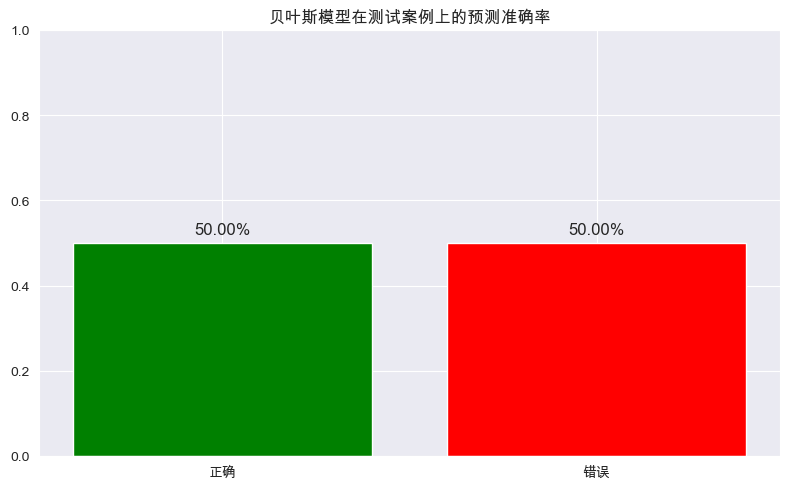

In [9]:
def predict_programme_with_bayes(scores, grade, gender):
    """
    使用训练好的贝叶斯模型预测某个学生的专业归属概率。

    参数:
        scores (list): 学生的各科成绩（与训练时特征一致��
        grade (int): 学生所在年级
        gender (int): 学生性别（假设1=男，2=女）

    返回:
        dict: 各个专业的概率分布，例如 {'A': 0.6, 'B': 0.3, 'C': 0.1}
    """
    # 检查给定年级是否有模型
    if grade not in grade_models:
        print(f"警告：年级 {grade} 没有训练模型")
        return {}

    # 获取对应年级的模型
    model_info = grade_models[grade]
    model = model_info['model']

    # 构建输入特征
    eps = 0.0000001  # 防止除零错误

    # 创建特征字典
    feature_dict = {
        'Q1': scores[0], 'Q2': scores[1], 'Q3': scores[2],
        'Q4': scores[3], 'Q5': scores[4], 'Gender': gender
    }

    # 计算比例特征
    for i in range(1, 6):
        for j in range(i + 1, 6):
            feature_dict[f'Q{i}_to_Q{j}'] = scores[i - 1] / (scores[j - 1] + eps)

    # 计算统计特征
    feature_dict['mean_score'] = np.mean(scores)
    feature_dict['std_score'] = np.std(scores)
    feature_dict['range_score'] = max(scores) - min(scores)
    feature_dict['cv_score'] = feature_dict['std_score'] / (feature_dict['mean_score'] + eps)

    # 计算归一化分数
    max_scores = [8, 8, 14, 10, 6]  # 每题满分
    for i in range(1, 6):
        feature_dict[f'Q{i}_norm'] = scores[i - 1] / max_scores[i - 1]

    # 转换为模型可用的特征向量
    X_input = pd.DataFrame([feature_dict])

    # 确保特征顺序与训练时一致
    feature_cols = model_info['features']
    X_input = X_input[feature_cols]

    # 获取模型支持的有效系别
    grade_df = df[df['Grade'] == grade]
    programme_counts = grade_df['Programme'].value_counts()
    valid_programmes = programme_counts[programme_counts >= 5].index.tolist()

    # 获取预测概率
    probs_array = model.predict_proba(X_input)

    # 将概率与对应类别组合
    classes = model.classes_
    probs_dict = {cls: prob for cls, prob in zip(classes, probs_array[0])}

    return probs_dict


# 测试案例
test_cases = [
    {'scores': [4, 0, 0, 0, 2], 'grade': 2, 'gender': 2, 'expected': 'A'},  # 低分A系学生
    {'scores': [8, 2, 2, 0, 0], 'grade': 2, 'gender': 2, 'expected': 'D'},  # 高分D系学生
    {'scores': [8, 2, 2, 7, 1], 'grade': 2, 'gender': 2, 'expected': 'A'},  # 中分A系学生
    {'scores': [8, 6, 14, 10, 3], 'grade': 2, 'gender': 2, 'expected': 'A'},  # A系学生
    {'scores': [8, 6, 14, 8, 0], 'grade': 2, 'gender': 2, 'expected': 'A'},
    {'scores': [8, 6, 12, 5, 2], 'grade': 2, 'gender': 2, 'expected': 'C'}
]

print("\n贝叶斯预测演示:")
correct_count = 0
total_cases = len(test_cases)

for case in test_cases:
    probs = predict_programme_with_bayes(case['scores'], case['grade'], case['gender'])
    print(probs)
    if not probs:
        print(f"⚠️ 预测失败: {case}")
        continue

    predicted = max(probs, key=probs.get)
    is_correct = predicted == case['expected']

    print(f"学生得分: {case['scores']}, 年级: {case['grade']}, 性别: {case['gender']}")
    print(f"预测系别: {predicted} ({'✅ 正确' if is_correct else '❌ 错误'}), 预期系别: {case['expected']}")
    print(f"各系别概率: {', '.join([f'{k}: {v:.4f}' for k, v in probs.items()])}")
    print()

    correct_count += is_correct

# 计算准确率
accuracy = correct_count / total_cases if total_cases else 0

# 可视化
plt.figure(figsize=(8, 5))
plt.bar(['正确', '错误'], [accuracy, 1 - accuracy], color=['green', 'red'])
plt.xticks(['正确', '错误'])
plt.title('贝叶斯模型在测试案例上的预测准确率')
plt.ylim(0, 1)
plt.text(0, accuracy + 0.02, f'{accuracy:.2%}', ha='center', fontsize=12, fontweight='bold')
plt.text(1, (1 - accuracy) + 0.02, f'{1 - accuracy:.2%}', ha='center', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

### 6. 在验证数据集上检验贝叶斯预测模型
验证预训练贝叶斯模型在独立测试集上的性能表现

验证数据集样本数量: 619
检测到系别使用数字编码，进行转换...
系别转换后的分布: 
Programme
A    249
D    217
B    118
C     35
Name: count, dtype: int64

年级 2 验证样本数: 581
年级 2 预测准确率: 0.5542 (322/581)

年级 3 验证样本数: 38
⚠️ 年级 3 没有训练好的模型，跳过

总体准确率: 0.5542 (322/581)


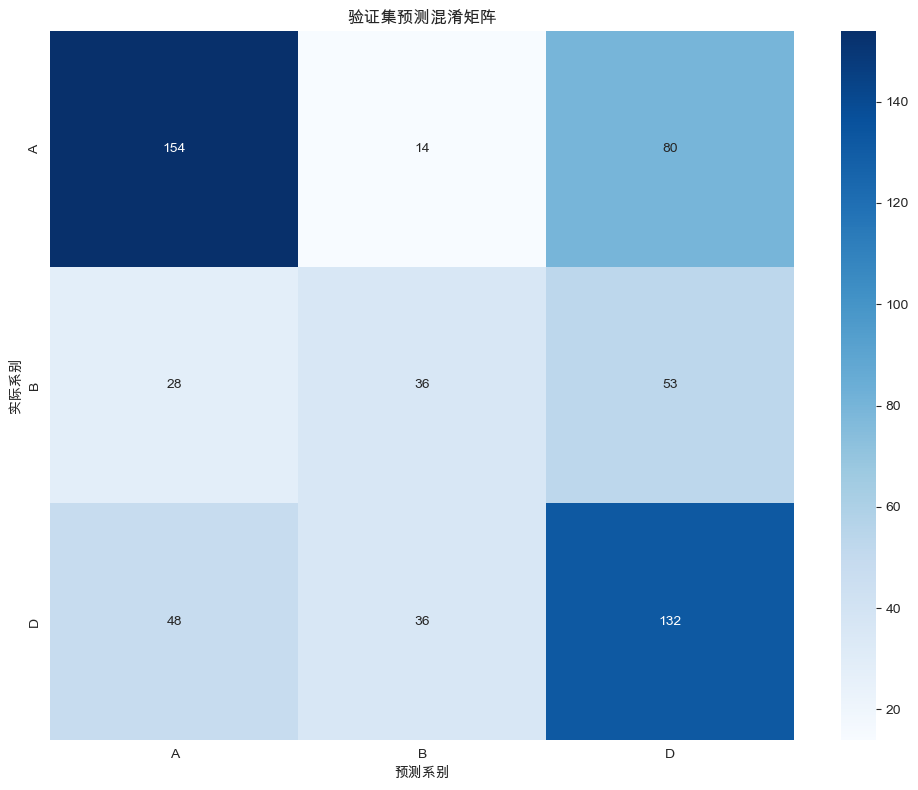

In [10]:
# 导入测试数据
test_df = pd.read_csv('./test_data.csv')
#贝叶斯模型并不需要独立测试集
print(f"验证数据集样本数量: {len(test_df)}")

# 系别映射（如果需要）
mapping = {'1': 'A', '2': 'B', '3': 'C', '4': 'D'}

# 检查是否需要转换系别编码
if test_df['Programme'].dtype == 'int64' or test_df['Programme'].iloc[0] in ['1', '2', '3', '4']:
    print("检测到系别使用数字编码，进行转换...")
    test_df['Programme'] = test_df['Programme'].astype(str).map(mapping)
    print(f"系别转换后的分布: \n{test_df['Programme'].value_counts()}")

# 初始化结果列表
results = {
    'actual': [],
    'predicted': [],
    'correct': [],
    'probabilities': [],
    'grade': [],
    'gender': []
}

# 按年级分组进行验证
for grade in sorted(test_df['Grade'].unique()):
    grade_test = test_df[test_df['Grade'] == grade]
    print(f"\n年级 {grade} 验证样本数: {len(grade_test)}")

    # 如果该年级没有训练模型，则跳过
    if grade not in grade_models:
        print(f"⚠️ 年级 {grade} 没有训练好的模型，跳过")
        continue

    correct_count = 0
    total_count = 0

    for _, student in grade_test.iterrows():
        scores = [student['Q1'], student['Q2'], student['Q3'], student['Q4'], student['Q5']]
        gender = student['Gender']
        actual_programme = student['Programme']

        # 预测系别
        probs = predict_programme_with_bayes(scores, grade, gender)
        if not probs:
            print(f"⚠️ 预测失败: 年级={grade}, 得分={scores}, 性别={gender}")
            continue

        predicted = max(probs, key=probs.get)
        is_correct = predicted == actual_programme

        # 保存结果
        results['actual'].append(actual_programme)
        results['predicted'].append(predicted)
        results['correct'].append(is_correct)
        results['probabilities'].append(probs)
        results['grade'].append(grade)
        results['gender'].append(gender)

        correct_count += is_correct
        total_count += 1

    # 计算该年级���准确率
    grade_accuracy = correct_count / total_count if total_count > 0 else 0
    print(f"年级 {grade} 预测准确率: {grade_accuracy:.4f} ({correct_count}/{total_count})")

# 计算总体准确率
overall_accuracy = sum(results['correct']) / len(results['correct']) if results['correct'] else 0
print(f"\n总体准确率: {overall_accuracy:.4f} ({sum(results['correct'])}/{len(results['correct'])})")

# 创建混淆矩阵 - 使用集合并集而非列表相加
all_programmes = sorted(list(set(results['actual']) | set(results['predicted'])))
cm = confusion_matrix(results['actual'], results['predicted'], labels=all_programmes)

# 绘制混淆矩阵热图
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=all_programmes,
            yticklabels=all_programmes)
plt.title('验证集预测混淆矩阵')
plt.xlabel('预测系别')
plt.ylabel('实际系别')
plt.tight_layout()
plt.show()